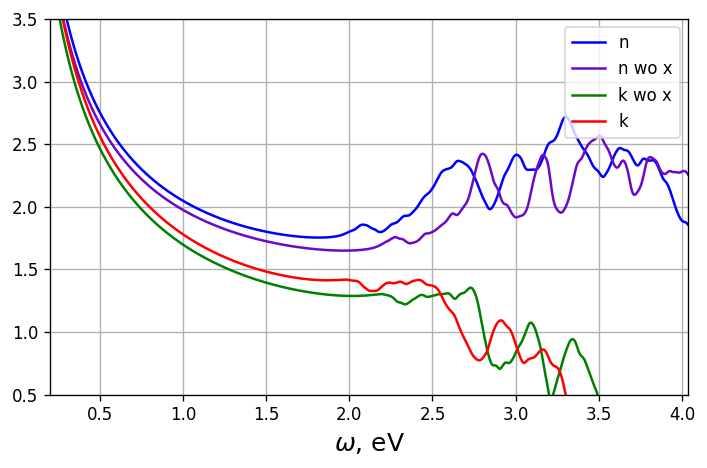

In [4]:
import mdirac as moire
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import shutil
import json
import matplotlib.pyplot as plt
import time

a = 1.9188*np.sqrt(3) # [A] Bieneck (2020) DFT WSe2
a0 = 0.52917 # [A] hydrogen 
r0 = 45 # [A] Nguyen WSe2 (2022) 
Eg = 2.02 # [eV] Nguyen WSe2 (2022)
Ry = 13.60565 # [eV] hydrogen
#me = 0.29 # [m0] Kormanyos WSe2 (2015)
#mh = 0.36 # [m0] Kormanyos WSe2 (2015)
m = 0.3
epstop = 1 # air
epsbottom = 1 # freestanding
eps = 0.5*(epstop+epsbottom)

Ry = Ry/Eg
t = np.sqrt(0.5*Ry*(1/m))*a0/a # in units of Eg
teff = 2*np.pi*t # 2pi from 2pi/a in monolayer hamiltonian
#continuum model parameters
wc = -0.0011/Eg # Guiqiang Yu (2021)
wv = -0.0097/Eg
Vc = 0.0068/Eg
psic = -89.7
Vv = 0.0089/Eg
psiv = -91
cm = moire.mdirac.ContModel(Vc,psic,wc,Vv,psiv,wv)

#keldysh interaction parameters
r0eff = 2*np.pi*r0/a
epseff = eps/Ry*a/a0/2

#optical slab model for transition from sigma to epsilion
d = 2*6.5 # [A], MoS2 thickness
beta = Ry*2*a0/d 

#grid density 
kstep0 = 0.01
#cell=kstep0*np.array([[1.,0.],[-0.5,0.5*np.sqrt(3)]])
# complicable with moire hamiltonian reciprocal vectors
cell=kstep0*np.array([[0.5*np.sqrt(3),0.5],[-0.5*np.sqrt(3),0.5]])
N = int(1/kstep0)
kmesh = moire.mesh.Parallelogram(N,cell)

#moire hamiltonian parameters
dim = 4
dim_ham = 4*dim**2
angle = 4.5
theta = angle*np.pi/180
k0 = 4./np.sqrt(3)*np.sin(0.5*theta)
levels = dim_ham//2 # number of levels taken below and on top of the gap, <= dim_ham/2
deg = 4 # valley+spin degeneracy
edge_v = dim_ham//2-1
edge_c = dim_ham//2

def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise

path = 'out/WS2/free/'+'kstep'+str(kstep0)+'angle'+str(angle)+'dim'+str(dim)
mkdir_p(path)

circle = kmesh.get_MBZ(scale=k0)
meshpath = '/mesh.png'
circle.savefig(path=(path+meshpath))

f = open('twist.ipynb')
data = json.load(f)
log = data['cells'][0]['source']
f.close()
out_f = open(path+"/log.json", "w")
json.dump(log, out_f, indent = 6)
out_f.close()

timelog = open(path+"/timelog.txt", "w")
startTime = time.time()
E,U = moire.mdirac.eighTwistDimMesh(circle,dim,k0,teff,cm)
executionTime = (time.time() - startTime)
timelog.write("TwistHamiltonian diagonalization time: " + str(executionTime) + '\n')

for i in np.arange(dim_ham//2):
    plt.plot(np.arange(E[:,i].shape[0]),E[:,i])
plt.savefig(path+'/disps_c.png',dpi=100)
plt.close()

for i in np.arange(dim_ham//2,dim_ham):
    plt.plot(np.arange(E[:,i].shape[0]),E[:,i])
plt.savefig(path+'/disps_v.png',dpi=100)
plt.close()

# plot dispersion in moire bz
moire.mdirac.PlotGKMG(dim,k0,kstep0,teff,cm,path=path)


keld=moire.interaction.Keldysh(epseff,r0eff,kstep0)
Wk=moire.interaction.sample_to_mesh(keld,kmesh)
Wklog = open(path+"/Wklog.txt", "w")
Wklog.write('k space, singularity resolved with integration over parallelogram -> 4.254' + '\n')
Wklog.write('Wk[0,0] '+str(Wk[0,0]) + '\n')
Wklog.write('Wk[0,1] '+str(Wk[0,1]))
Wklog.close()
kmeshbz = moire.mesh.Parallelogram(N,k0*cell)
Wkbz = moire.interaction.sample_to_mesh(keld,kmeshbz)
keldpath = '/keld.png'
kmeshbz.savefig(c=np.log(np.abs(Wkbz)),path=(path+keldpath),dpi=100,s=100)

startTime = time.time()
Wkk=moire.interaction.pairs(circle,Wk)
executionTime = (time.time() - startTime)
timelog.write("Keldysh pairing time: " + str(executionTime) + '\n')

Ex=np.zeros((circle.Np,levels,levels),dtype=np.float64)
Ux=np.zeros((circle.Np,circle.Np,levels,levels),dtype=np.complex128)

startTime = time.time()
for ind_v in np.arange(edge_v,edge_v-levels,-1):
    for ind_c in np.arange(edge_c,edge_c+levels,1):
        H = moire.mdirac.TwistHbse(E,U,Wkk,ind_c,ind_v)
        i = edge_v-ind_v
        j = ind_c - edge_c
        Ex[:,i,j], Ux[:,:,i,j] = np.linalg.eigh(H)
executionTime = (time.time() - startTime)
timelog.write("BSE diagonalization time: " + str(executionTime) +'\n')

Exlog = open(path+"/Exlog.txt", "w")
Exlog.write('Exciton energies in energy units of gap: \n')
Exlog.write(str(Ex[:5,:]) + '\n')
Exlog.write('Exciton energies in eV energy units: \n')
Exlog.write(str(Eg*Ex[:5,:]) + '\n')
Eb=Eg*(1.-Ex[:5,:])
Exlog.write('Exciton binding energies in eV: \n')
Exlog.write(str(Eb[:5,:]))
Exlog.close()

startTime = time.time()
sx=np.array([[0,1],[1,0]])
factorsigma=deg*kmesh.vcell*2*Ry*(a0/a)**2*(1/m)*1.j
omega=np.linspace(1.e-5,2.,1000)
eta=1.5e-2
keys0 = np.identity(dim_ham//2)
Sx=np.kron(keys0,sx)
csxv=np.zeros((circle.Np,levels,levels),dtype=np.complex)
xsx0=np.zeros((circle.Np,levels,levels),dtype=np.complex)
dE=np.zeros((circle.Np,levels,levels),dtype=np.float64)

sigma=np.zeros((omega.shape[0],levels,levels),dtype=np.complex128)
sigma0=np.zeros((omega.shape[0],levels,levels),dtype=np.complex128)

for ind_v in np.arange(edge_v,edge_v-levels,-1):
    for ind_c in np.arange(edge_c,edge_c+levels,1):
        i = edge_v-ind_v
        j = ind_c - edge_c
        csxv[:,i,j] = moire.mdirac.cov_matrix_elements(Sx,U,ind_c,ind_v)
        xsx0[:,i,j] = moire.mdirac.exciton_elements(Ux[:,:,i,j],csxv[:,i,j])
        dE[:,i,j] = E[:,ind_c]-E[:,ind_v]
        sigma0[:,i,j]=moire.mdirac.get_sigma(factorsigma,omega+1.j*eta,dE[:,i,j],csxv[:,i,j])
        sigma[:,i,j]=moire.mdirac.get_sigma(factorsigma,omega+1.j*eta,Ex[:,i,j],xsx0[:,i,j])
executionTime = (time.time() - startTime)
timelog.write("Matrix element calculation: " + str(executionTime))


fsumlog = open(path+"/fsum.txt", "w")
fsumlog.write('Transition sum rules for different transitions in order 0123 -> 12,13,02,03: \n')
for i in np.arange(levels):
    for j in np.arange(levels):
        fsumlog.write(str(np.sum(np.abs(csxv[:,i,j])**2))+'\t'+str(np.sum(np.abs(xsx0[:,i,j])**2))+'\n')
fsumlog.close()

sigma0=np.sum(sigma0,axis=(1,2))
sigma=np.sum(sigma,axis=(1,2))
scaleomega=Eg/500

def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    fig,ax=plt.subplots(dpi=120)
    # *4 to calculate in units of e2/4h
    ax.plot(scaleomega*omegas,sigma0.real[left_cut:right_cut]*4,c='b',label='ReSigma wo x')
    ax.plot(scaleomega*omegas,sigma.real[left_cut:right_cut]*4,c='r',label='ReSigma')
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.set_ylabel(r'Re $\sigma$/$\sigma_0$',fontsize=15)
    ax.vlines(x=[Eg], ymin=0,ymax=np.max(sigma0.real)*4,colors=['tab:orange'], ls='--', lw=5, alpha=0.5,label='opt bg')
    ax.legend(loc='upper right')
    realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(realsigmapath,dpi=120)
    plt.close()
    fig,ax=plt.subplots(dpi=120)
    ax.plot(scaleomega*omegas,sigma.imag[left_cut:right_cut]*4,c='r',label='ImSigma')
    ax.plot(scaleomega*omegas,sigma0.imag[left_cut:right_cut]*4,c='b',label='ImSigma wo x')
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.set_ylabel(r'Im $\sigma$/$\sigma_0$',fontsize=15)
    ax.vlines(x=[Eg], ymin=np.min(sigma0.imag)*4,ymax=np.max(sigma0.imag)*4,
              colors=['tab:orange'], ls='--', lw=5, alpha=0.5,label='opt bg')
    imsigmapath = path + '/imsigma'+str(left_cut)+'_'+str(right_cut)+'.png'
    ax.legend()
    plt.savefig(imsigmapath,dpi=120)
    sigmatofile = np.column_stack([Eg*omega[left_cut:right_cut], sigma.real[left_cut:right_cut]])
    np.savetxt(path+'/Resigma.txt',sigmatofile)
    plt.close()

def OptConstsPlotter(left_cut, right_cut,scaleomega,beta,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    eps = 1+4*np.pi*sigma0[left_cut:right_cut]/omega[left_cut:right_cut]*beta*1.j
    refr = np.sqrt(eps)
    eps_x = 1+4*np.pi*sigma[left_cut:right_cut]/omega[left_cut:right_cut]*beta*1.j
    refr_x = np.sqrt(eps_x)
    fig,ax=plt.subplots(dpi=120)
    ax.plot(scaleomega*omegas,refr_x.real,'b',label='n')
    ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n wo x')
    ax.plot(scaleomega*omegas,refr.imag,c='g',label='k wo x')
    ax.plot(scaleomega*omegas,refr_x.imag,'r',label='k')
    ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
    ax.set_ylim([0,7])
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.legend(loc='upper right')
    fig.tight_layout()
    optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(optconstspath)
    ktofile = np.column_stack([Eg*omega[left_cut:right_cut], refr_x.imag])
    np.savetxt(path+'/extinction.txt',ktofile)
    plt.close()

    
SigmaPlotter(100,1000,scaleomega,omega,sigma)
SigmaPlotter(400,600,scaleomega,omega,sigma)
OptConstsPlotter(100,1000,scaleomega,beta,omega,sigma)
OptConstsPlotter(400,600,scaleomega,beta,omega,sigma)


timelog.close()